# Examples of XAI-Lib Usage for image data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Intgrad

In [2]:
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'

# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

# Load the model
MNIST_CNN = tf.keras.models.load_model('./models/cnn_simple_mnist_no_pickle')
MNIST_CNN.trainable=False
MNIST_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

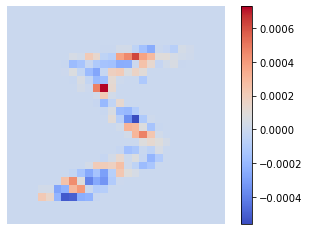

In [3]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit(1,'black')

# 3) Explain an Instance
image = MNIST_x_data_train[0,:].reshape(28,28,1)
scores = ig.explain(image)

plt.imshow(scores,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

In [4]:
# Load data
imagenet_x_data = pickle.load(open('./datasets/imagenet.p','rb'))
imagenet_y_data = pickle.load(open('./datasets/imagenet_labels.p','rb'))
imagenet_map = pickle.load(open('./datasets/imagenet_mapping_labels.p','rb'))

# Load Model
imagenet_VGG = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=True,weights='imagenet')
imagenet_VGG.trainable = False
imagenet_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

  0%|          | 0/500 [00:00<?, ?it/s]

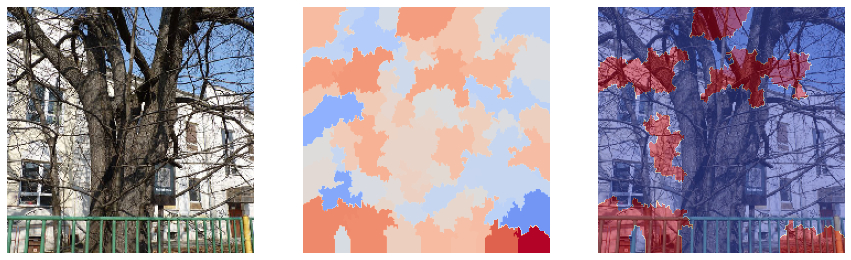

In [7]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb

F, ax = plt.subplots(1,3,figsize=(15,5))
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(imagenet_VGG)

# 2) Fit the Explainer
lm.fit()

# 3) Explain an Instance
explanation = lm.explain(imagenet_x_data[idx], num_samples=500)

ax[0].imshow(imagenet_x_data[idx].astype(int))
ax[0].axis('off')

#plot heatmap
ind =  explanation.top_labels[0]
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
ax[1].imshow(heatmap, cmap = 'coolwarm', vmin  = -heatmap.max(), vmax = heatmap.max())
ax[1].axis('off')

#plot overlap
temp, mask = explanation.get_image_and_mask(np.argmax(imagenet_VGG.predict(imagenet_x_data[idx:idx+1])), 
                                            positive_only=True, 
                                            num_features=10, 
                                            hide_rest=False, 
                                            min_weight = 0.01)

ax[2].imshow(imagenet_x_data[idx].astype(int))
ax[2].imshow(mask,alpha=0.5,cmap='coolwarm')
ax[2].axis('off');